In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
import sklearn.preprocessing

from src.nnpehgp import NNPEHGP
from src import evaluator
from tqdm import tqdm
import ot

In [2]:
def f1(X, add_noise=False):
    target = X * np.sin(X) + np.sqrt(16*X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 1, size=target.shape)
    return target.squeeze()

f2 = np.cos
transform = np.exp

# Test Data

In [3]:
X = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)

# Compute loc and scale as functions of input X
loc = f1(X, add_noise=False).reshape(-1,1)
scale = transform(f2(X))

# Sample outputs Y from Gaussian Likelihood
Y = np.random.normal(loc, scale)

# Training Data

In [4]:
rng = np.random.RandomState(0)
X_train = rng.uniform(0, 10, size=20).reshape(-1, 1)
mean_train = f1(X_train, add_noise=False).reshape(-1,1)
scale_train = transform(f2(X_train))

np.random.seed(17)
y_train = np.random.normal(mean_train, scale_train)

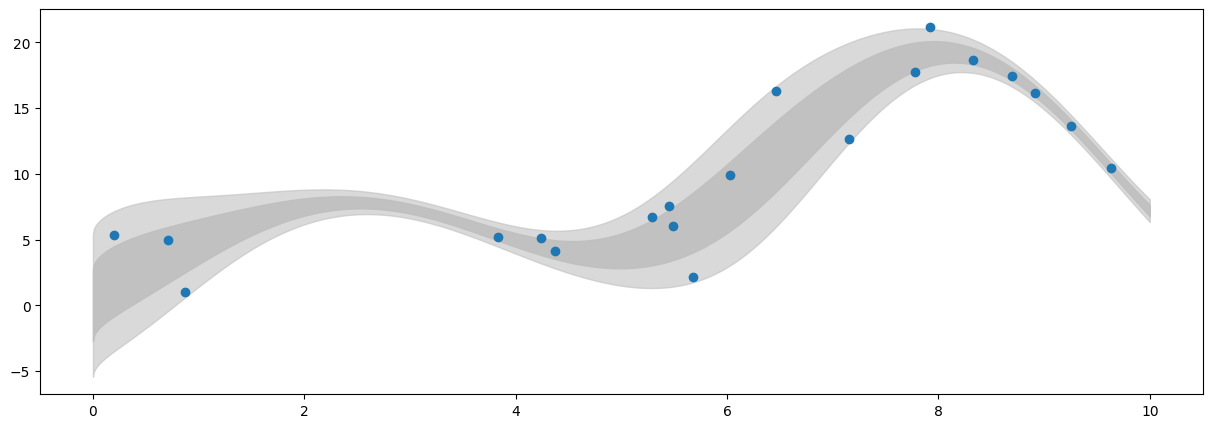

In [5]:
plt.figure(figsize=(15, 5))
x = X.squeeze()
for k in (1, 2):
    lb = (loc - k * scale).squeeze()
    ub = (loc + k * scale).squeeze()
    plt.fill_between(x, lb, ub, color="silver", alpha=1 - 0.05 * k ** 3)
plt.scatter(X_train, y_train)

# Improved Most Likely Heteroscedastic Gaussian Process approach

In [6]:
# Normalize X
normalizer = sklearn.preprocessing.StandardScaler().fit(X_train)
X_train_norm = normalizer.transform(X_train)
X_norm = normalizer.transform(X)

In [7]:
# define the model
def hgp_constructor(X_train_norm, y_train, kernel, kernel_noise):
    model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25)
    model_noise = GaussianProcessRegressor(kernel=kernel_noise, n_restarts_optimizer=25)

    hgp = NNPEHGP(model, model_noise, v=2, k=6)

    # fit the model
    hgp.fit(X_train_norm, y_train.flatten())

    return hgp

In [8]:
kernel = ConstantKernel(1.0) * RBF(length_scale=1e1, length_scale_bounds=(1e-3, 1e2)) + WhiteKernel(
        noise_level=1, noise_level_bounds=(1e-2, 1e1)
    )
kernel_noise = ConstantKernel(1.0) * RBF(length_scale=1e1, length_scale_bounds=(1e-3, 1e2)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-2, 1e1)
)
hgp = hgp_constructor(X_train_norm, y_train, kernel, kernel_noise)

/Users/fazaghifari/miniconda3/envs/raenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [9]:
# make a prediction 
Y_pred, Std_pred = hgp.predict(X_norm, return_std="multi")

std_al, std_ep = Std_pred
std_tot = np.sqrt(std_al**2 + std_ep**2)

Text(0, 0.5, 'z')

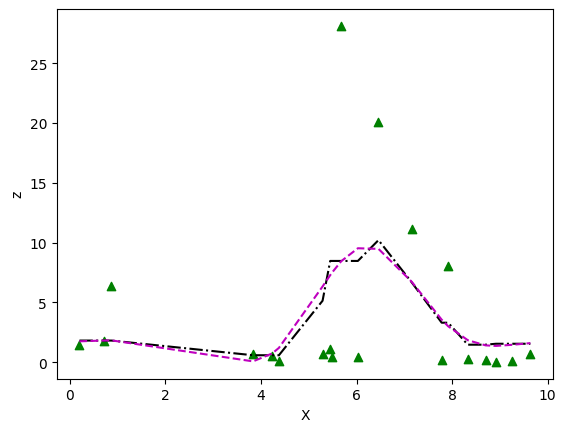

In [10]:
sorted_xtrain = np.sort(X_train, axis=0)
sorted_xtrain_norm = np.sort(X_train_norm, axis=0)
plt.scatter(X_train, (hgp.z), marker="^", color="green")
plt.plot(sorted_xtrain, (hgp.model_smoothing.predict(sorted_xtrain_norm)), "-.k")
plt.plot(sorted_xtrain, (hgp.model_noise.predict(sorted_xtrain_norm)), "--m")
plt.xlabel("X")
plt.ylabel("z")

In [11]:
hgp.model_noise.kernel_

4.09**2 * RBF(length_scale=0.492) + WhiteKernel(noise_level=0.521)

In [12]:
hgp.model.kernel_

9.08**2 * RBF(length_scale=0.736) + WhiteKernel(noise_level=0.01)

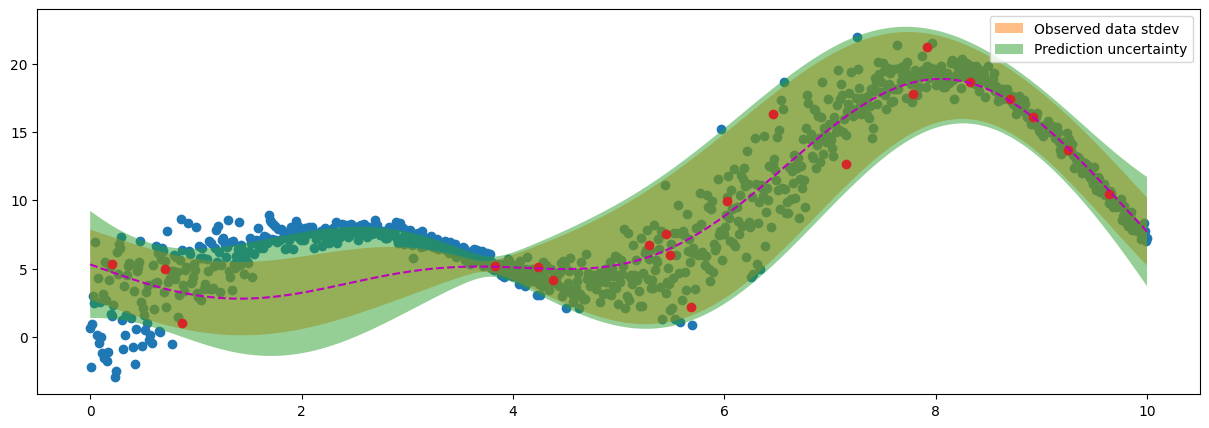

In [13]:
plt.figure(figsize=(15, 5))
plt.scatter(X,Y)
x = X.squeeze()
plt.fill_between(
    X.ravel(),
    Y_pred - 1.96 * (std_al),
    Y_pred + 1.96 * (std_al),
    alpha=0.5,
    label=r"Observed data stdev",
)
plt.fill_between(
    X.ravel(),
    Y_pred - 1.96 * std_tot,
    Y_pred + 1.96 * std_tot,
    alpha=0.5,
    label=r"Prediction uncertainty",
)
plt.plot(X, Y_pred, "--m")
plt.scatter(X_train, y_train)
plt.legend()

In [14]:
def avg_emd(X_test, model):
    mean_act = f1(X, add_noise=False).reshape(-1,1)
    std_act = transform(f2(X))

    mean_pred, unc_pred = model.predict(X_test, return_std="multi")
    std_al, std_ep = unc_pred
    
    d_wass_list = []
    dist_list = []
    m2_list = []
    for i,x in tqdm(enumerate(X_test)):
        # actual distribution
        act_dist = [mean_act[i,:], std_act[i,:]]
        pred_dist = [mean_pred[i], std_al[i]]

        d_wass, dists, m2 = evaluator.wasserstein2(act_dist, pred_dist)
        d_wass_list.append(d_wass)
        dist_list.append(dists)
        m2_list.append(m2)
    
    avg_wass = np.mean(d_wass_list)

    return avg_wass, dist_list, m2_list

In [15]:
avg_wass, dist_list, m2_list = avg_emd(X_norm, hgp)
avg_wass

1000it [00:00, 1259.11it/s]


3.980114486987689

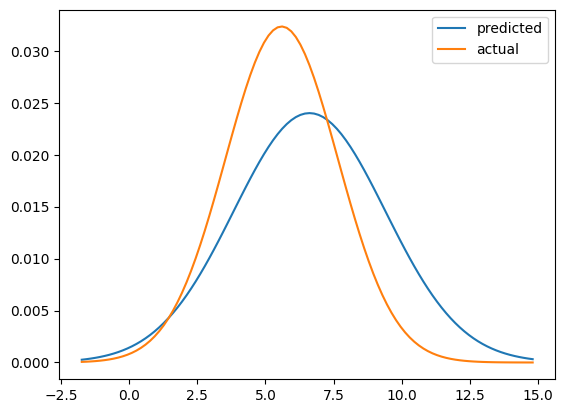

In [16]:
idx = 550
xdist, act_gauss, pred_gauss = dist_list[idx]
m2 = m2_list[idx]

plt.plot(xdist, pred_gauss, label="predicted")
plt.plot(xdist, act_gauss, label="actual")
plt.legend()

In [17]:
ot.emd2(pred_gauss, act_gauss, m2)

1.5138497308602255

# Case 2

In [18]:
def fun_1d(X):
    y = X + X * np.sin(2*np.pi*(X-3))**2 + 2 * np.exp(X-2)
    return y

def noise_fun(X):
    noise = 0.2 * X
    return noise

In [19]:
X_test = np.linspace(start=0, stop=1, num=1000).reshape(-1, 1)
X_train = np.linspace(start=0, stop=1, num=40).reshape(-1, 1)
y_test_mean = fun_1d(X_test)

np.random.seed(42)
y_train = np.random.normal(fun_1d(X_train), noise_fun(X_train))

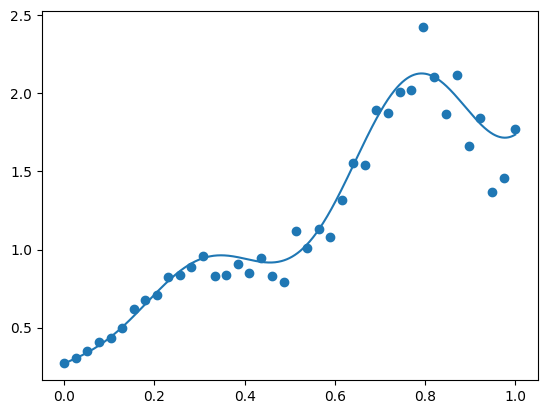

In [20]:
plt.plot(X_test, y_test_mean)
plt.scatter(X_train, y_train)

In [21]:
kernel = ConstantKernel(1.0) * RBF(length_scale=1e1, length_scale_bounds=(1e-3, 1e2)) + WhiteKernel(
        noise_level=1, noise_level_bounds=(1e-3, 1e1)
    )
kernel_noise = ConstantKernel(1.0) * RBF(length_scale=1e1, length_scale_bounds=(1e-3, 1e2)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-4, 8e-2)
)
hgp2 = hgp_constructor(X_train, y_train, kernel, kernel_noise)

/Users/fazaghifari/miniconda3/envs/raenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/fazaghifari/miniconda3/envs/raenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [22]:
# make a prediction 
Y_pred, Std_pred = hgp2.predict(X_test, return_std="multi")

std_al, std_ep = Std_pred
std_tot = np.sqrt(std_al**2 + std_ep**2)

Text(0, 0.5, 'z')

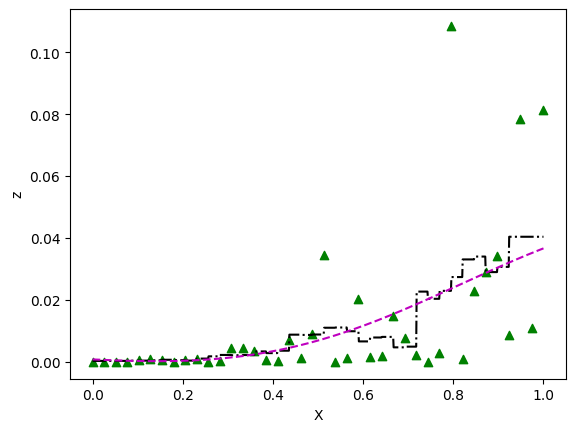

In [23]:
sorted_xtrain = np.sort(X_train, axis=0)
plt.scatter(X_train, (hgp2.z), marker="^", color="green")
plt.plot(X_test, (hgp2.model_smoothing.predict(X_test)), "-.k")
plt.plot(X_test, (hgp2.model_noise.predict(X_test)), "--m")
plt.xlabel("X")
plt.ylabel("z")

In [24]:
print(f"Model: {hgp2.model.kernel_}")
print(f"Model Noise: {hgp2.model_noise.kernel_}")

Model: 1.06**2 * RBF(length_scale=0.216) + WhiteKernel(noise_level=0.01)
Model Noise: 0.029**2 * RBF(length_scale=0.601) + WhiteKernel(noise_level=0.0001)


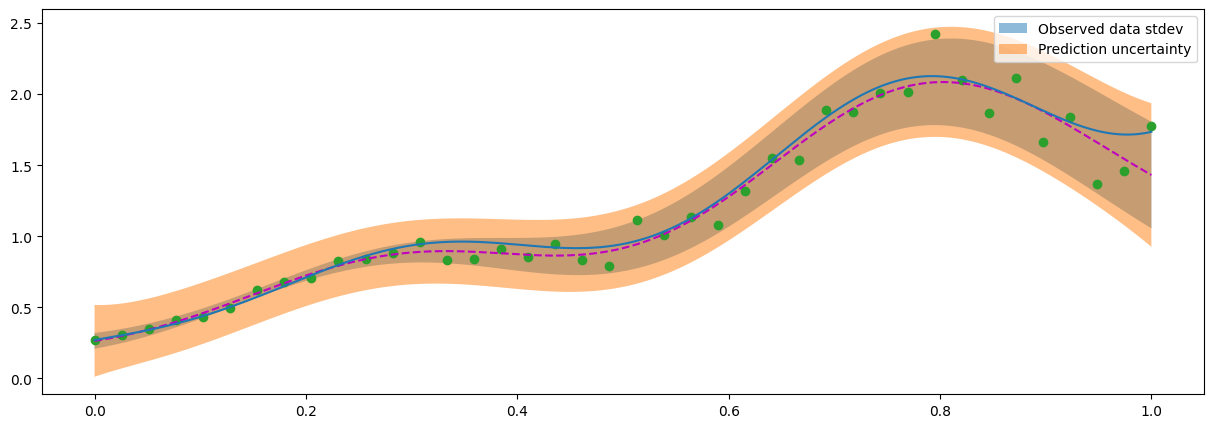

In [25]:
plt.figure(figsize=(15, 5))
x = X_test.squeeze()
plt.fill_between(
    X_test.ravel(),
    Y_pred - 1.96 * (std_al),
    Y_pred + 1.96 * (std_al),
    alpha=0.5,
    label=r"Observed data stdev",
)
plt.fill_between(
    X_test.ravel(),
    Y_pred - 1.96 * std_tot,
    Y_pred + 1.96 * std_tot,
    alpha=0.5,
    label=r"Prediction uncertainty",
)
plt.plot(X_test, Y_pred, "--m")
plt.plot(X_test, y_test_mean)
plt.scatter(X_train, y_train)
plt.legend()

In [26]:
def avg_emd(X_test, model):
    mean_act = fun_1d(X_test)
    std_act = noise_fun(X_test)

    mean_pred, unc_pred = model.predict(X_test, return_std="multi")
    std_al, std_ep = unc_pred
    
    d_wass_list = []
    dist_list = []
    m2_list = []
    for i,x in tqdm(enumerate(X_test)):
        # actual distribution
        act_dist = [mean_act[i,:], std_act[i,:]]
        pred_dist = [mean_pred[i], std_al[i]]

        d_wass, dists, m2 = evaluator.wasserstein2(act_dist, pred_dist)
        d_wass_list.append(d_wass)
        dist_list.append(dists)
        m2_list.append(m2)
    
    avg_wass = np.mean(d_wass_list)

    return avg_wass, dist_list, m2_list

In [27]:
avg_wass, dist_list, m2_list = avg_emd(X_test, hgp2)
avg_wass

1000it [00:00, 1059.26it/s]


0.0036180140990219973

In [28]:
act_noise = noise_fun(X_test).flatten()
pred_noise = std_al

In [29]:
evaluator.noise_smse(pred_noise,act_noise)

0.06819360532969083

In [30]:
evaluator.nlpd_loss(y_test_mean, Y_pred, std_tot**2)

-16.689851843801172

In [31]:
idx = 990
xdist, act_gauss, pred_gauss = dist_list[idx]
m2 = m2_list[idx]

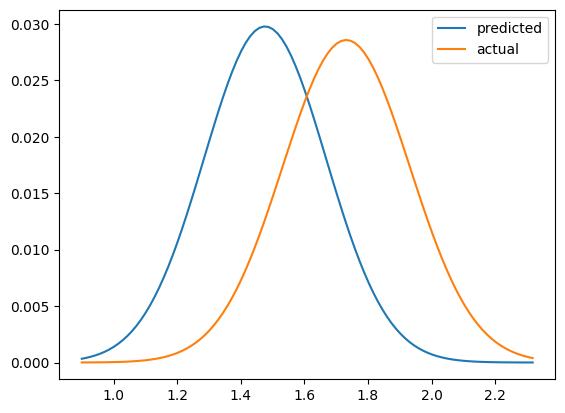

In [32]:
plt.plot(xdist, pred_gauss, label="predicted")
plt.plot(xdist, act_gauss, label="actual")
plt.legend()

In [33]:
ot.emd2(pred_gauss, act_gauss, m2)

0.06439478921122942